<a href="https://colab.research.google.com/github/sarthakkaushik/Helper-Codes/blob/main/human_protein_atlas_with_tf_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="font-family:candara; background:#99ffff; font-size: 30px; test-align: center;">HUMAN PROTEIN ATLAS</span>

The word *Protein* comes from Greek word *Proteios* meaning primary or in the lead. Proteins are of immense importance in our body. From catalysing reactions and passing signals at cellular level to growth and maintainance of tissues, many of the major life functions are carried out by proteins.

But why did I choose this topic??
* Instead of one RGB image, four channels images i.e. red, green, blue, yellow images are provided separately.
* Multilabel classification.

Moreover, I would like to use **tf.data** API which enables us to build asynchronous and highly efficient input pipeline.

So, let's get started.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import matplotlib.pyplot as plt
import os
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from keras import applications
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
from keras.optimizers import Adam

In [ ]:
df = pd.read_csv('/kaggle/input/human-protein-atlas-image-classification/train.csv')

In [ ]:
INPUT_SHAPE = (512, 512, 3)
BATCH_SIZE = 16
path_to_train = '/kaggle/input/human-protein-atlas-image-classification/train/'

In [ ]:
df["complete_path"] = path_to_train + df["Id"]

In [ ]:
df.head()

,Id,Target,complete_path
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,/kaggle/input/human-protein-atlas-image-classi...
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,/kaggle/input/human-protein-atlas-image-classi...
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,/kaggle/input/human-protein-atlas-image-classi...
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,/kaggle/input/human-protein-atlas-image-classi...
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,/kaggle/input/human-protein-atlas-image-classi...


# <span style="font-family:candara; background:#99ffff; font-size: 25px; test-align: center;">PLOTTING RANDOM CELL IMAGES</span>

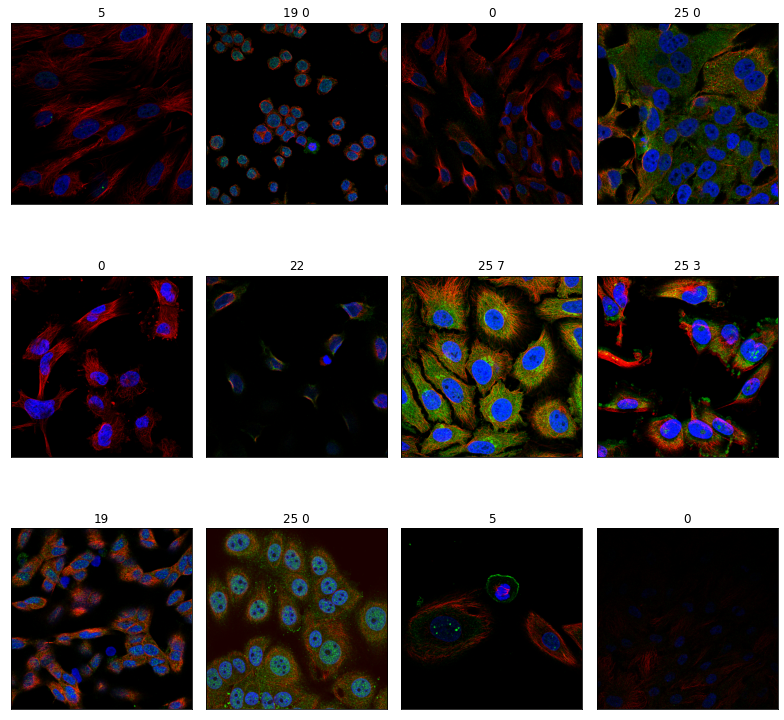

In [ ]:
import random
fig, axes = plt.subplots(3, 4, figsize=(11, 11))
for i in range(3):
    for j in range(4):
        idx = random.randint(0, df.shape[0])
        row = df.iloc[idx,:]
        path = row.complete_path
        red = np.array(Image.open(path + '_red.png'))
        green = np.array(Image.open(path + '_green.png'))
        blue = np.array(Image.open(path + '_blue.png'))
        im = np.stack((
                red,
                green,
                blue),-1)
        axes[i][j].imshow(im)
        axes[i][j].set_title(row.Target)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
fig.tight_layout()
fig.show();

In [ ]:
train, val = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
print(f'Shape of train: {train.shape}')
print(f'Shape of val: {val.shape}')

Shape of train: (24857, 3)
Shape of val: (6215, 3)


It may happen that row.Target.split() won't work. In that case, you can try row.Target.str.split() instead.

In [ ]:
def get_clean_data(df):
    targets = []
    paths = []
    for _, row in df.iterrows():
        target_np = np.zeros((28))
        t = [int(t) for t in row.Target.split()]
        target_np[t] = 1
        targets.append(target_np)
        paths.append(row.complete_path)
    return np.array(paths), np.array(targets)

In [ ]:
train_path, train_target = get_clean_data(train)
val_path, val_target = get_clean_data(val)

In [ ]:
print(f'Train path shape: {train_path.shape}')
print(f'Train target shape: {train_target.shape}')
print(f'Val path shape: {val_path.shape}')
print(f'Val target shape: {val_target.shape}')

Train path shape: (24857,)
Train target shape: (24857, 28)
Val path shape: (6215,)
Val target shape: (6215, 28)


# <span style="font-family:candara; background:#99ffff; font-size: 25px; test-align: center;">CREATING DATASET FROM FILE AND TARGETS</span>

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((train_path, train_target))
val_data = tf.data.Dataset.from_tensor_slices((val_path, val_target))

# <span style="font-family:candara; background:#99ffff; font-size: 25px; test-align: center;">READING IMAGES FROM FILES</span>

In [ ]:
def load_data(path, target):
    red = tf.squeeze(tf.image.decode_png(tf.io.read_file(path+'_red.png'), channels=1), [2])
    blue = tf.squeeze(tf.image.decode_png(tf.io.read_file(path+'_blue.png'), channels=1), [2])
    green = tf.squeeze(tf.image.decode_png(tf.io.read_file(path+'_green.png'), channels=1), [2])
    img = tf.stack((
                red,
                green,
                blue), axis=2)
    return img, target

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = train_data.map(load_data, num_parallel_calls=AUTOTUNE)
val_data = val_data.map(load_data, num_parallel_calls=AUTOTUNE)

If you want you can also resize the images using **tf.image.resize_images** function. I would like to keep the original dimensions :)

# <span style="font-family:candara; background:#99ffff; font-size: 25px; test-align: center;">IMAGE AUGMENTATION</span>
Now, I augment the training set images below by appling random contrast, brightness and flip. There are multiple other augmentations that you can apply.

In [ ]:
def image_augment(img, target):
    img = tf.image.random_contrast(img, lower=0.3, upper=2.0)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    return img, target
    
train_data = train_data.map(image_augment, num_parallel_calls=AUTOTUNE)

In [ ]:
train_data_batches = train_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_data_batches = val_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# <span style="font-family:candara; background:#99ffff; font-size: 25px; test-align: center;">TRAINING</span>

Loading pretrained ResNet50 model, adding final layers and training it:

In [ ]:
resnet_model = applications.ResNet50(include_top=False, weights='imagenet')

resnet_model.trainable = True

input_layer = Input(shape=INPUT_SHAPE)
x = resnet_model(input_layer)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(28, activation='sigmoid')(x)
model = Model(input_layer, output)

model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
flatten (Flatten)            (None, 524288)            0         
_________________________________________________________________
dropout (Dropout)            (None, 524288)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               268435968 
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_______________________________________________________

In [ ]:
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['binary_accuracy'])

In [ ]:
history = model.fit(train_data_batches, steps_per_epoch = 150, validation_data = val_data_batches, epochs=3)

Epoch 1/3
150/150 [==============================] - 189s 1s/step - loss: 0.4033 - binary_accuracy: 0.9292 - val_loss: 2.9932 - val_binary_accuracy: 0.9386
Epoch 2/3
150/150 [==============================] - 135s 899ms/step - loss: 0.1927 - binary_accuracy: 0.9387 - val_loss: 0.2261 - val_binary_accuracy: 0.9422
Epoch 3/3
150/150 [==============================] - 135s 900ms/step - loss: 0.1854 - binary_accuracy: 0.9412 - val_loss: 0.3889 - val_binary_accuracy: 0.9407


To get more information about tf.data you can refer to it's [official docs](http://www.tensorflow.org/guide/data)

**If you like my notebook, please upvote it :)**